<center><h1>SIFT & BoW</h1></center>




In [ ]:
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
!unzip TP1-2-data.zip
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/1-ab/tools.py

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
%run 'tools.py'
from os.path import join

data_path = "data"

# Part 1 : SIFT

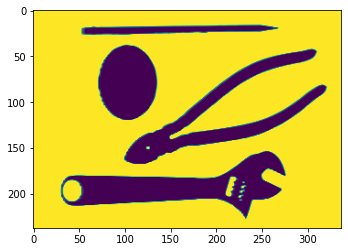

In [ ]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I)

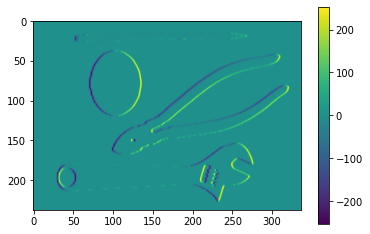

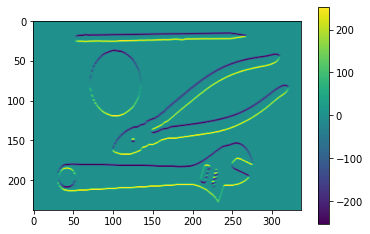

In [ ]:
def compute_grad(I):
    hx = np.array([0.5,1,0.5]).reshape(3,1)
    hy = np.array([-0.5,0,0.5]).reshape(3,1)

    Mx = hy@hx.T
    My = hx@hy.T

    Ix = conv_separable(I,hy,hx)
    Iy = conv_separable(I,hx,hy)
    
    return Ix, Iy

# Example
Ix, Iy = compute_grad(I)

plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [ ]:
def compute_grad_mod_ori(I):
    Ix,Iy = compute_grad(I)
    Gn = np.sqrt(Ix**2 + Iy**2)
    
    Go = compute_grad_ori(Ix,Iy,Gn)
    return Gn, Go

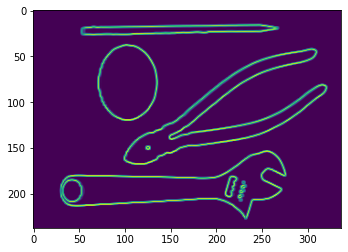

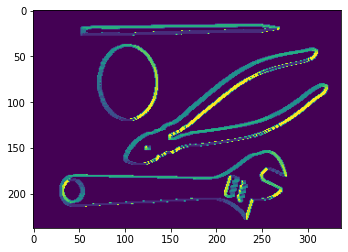

In [ ]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)
plt.show()
plt.imshow(Go)
plt.show()

In [ ]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))
    gpond = g_n*gaussian_mask(4)
    for j in range(4):
      for i in range(4):
        if g_o[i,j]!=-1:

          hist[g_o[i,j]] += gpond[i,j]
    return hist
  

In [ ]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        Gn = Gn * mask
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

In [ ]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
#display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    k, sift_size = 16, 128
    g_m, g_o = compute_grad_mod_ori(im)
    
    # calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), sift_size))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            g_m_r = g_m[xi:xi+k, yj:yj+k]
            g_o_r = g_o[xi:xi+k, yj:yj+k]
            sift = compute_sift_region(g_m_r, g_o_r)
            # SIFT du patch de coordonnee (xi, yj)
            sifts[i, j, :] = sift
            
    return sifts

# Compute SIFT

The computation can take several minutes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
max_images_per_class = 10  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

# Part 2 : Visual dictionnary

In [ ]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [ ]:
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    
    
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # compute kmeans on `sift`, get cluster centers, add zeros vector
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, verbose=verbose)
    kmeans.fit(sift)
    clusters = kmeans.cluster_centers_
    
    return np.vstack((clusters, np.zeros(128).reshape(1, -1)))

In [ ]:
%run 'tools.py'
# Run the visual dict computation (saved the first time)

vdict = compute_visual_dict(sifts_list_by_image)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 853415.0048821548
start iteration
done sorting
end inner loop
Iteration 1, inertia 843130.2018518518
start iteration
done sorting
end inner loop
Iteration 2, inertia 843130.2018518518
center shift 0.000000e+00 within tolerance 3.796767e-02


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

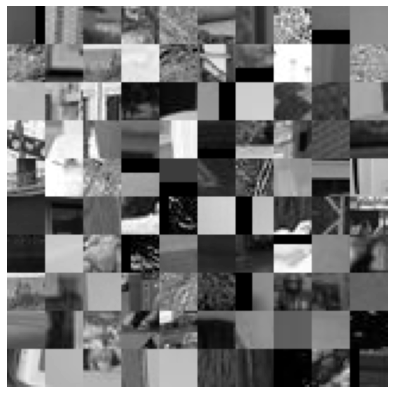

'centers = list(range(20))\nfor center in centers:\n  center_vect = vdict[center]\n  dist = ((sifts - center_vect)**2).sum(axis=1)\n  # get best 100\n  top100 = dist.argsort()[:100]\n  top100_regions = regions[top100]\n  display_images(top100_regions) # Show 100 random regions\n  break\n\nn_clusters = vdict.shape[0]\n\nchoix_cluster = np.random.choice(n_clusters,100)\n\nfor i in set(np.random.random_integers(0,1001,10)):\n  center_vect = vdict[i]\n  dist = ((sifts - center_vect)**2).sum(axis=1)\n  # get best 100\n  top100 = dist.argsort()[:100]\n  top100_regions = regions[top100]\n  display_images(top100_regions) # Show 100 random \n'

In [ ]:
# Study of the dict
%run 'tools.py'
# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions


"""centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions
  break

n_clusters = vdict.shape[0]

choix_cluster = np.random.choice(n_clusters,100)

for i in set(np.random.random_integers(0,1001,10)):
  center_vect = vdict[i]
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random 
"""


# Partie 3 : BoW

In [ ]:
# Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])
    #dist = np.zeros(vdict.shape[0])
    #compute distance from image sifts to centroid
    
    for sift in sifts: 
      dist = np.zeros(vdict.shape[0])
      for i,centroid in enumerate(vdict): 
        
        dist[i]=(np.linalg.norm(sift-centroid)**2)
      choix = np.argmin(dist)
      feats[choix] += 1 
      
    feats/= np.linalg.norm(feats) 

    return feats

In [ ]:
# Visualize your BoW on an image
liste = np.random.choice(len(inames),50)
for l in liste:

  iname = inames[l]
  ipath = os.path.join(dir_sc, iname)
  im = read_grayscale(ipath)
  sift = compute_sift_image(im)
  sift = (sift * 255).astype('uint8')
  regions = compute_regions(im)
  feats = compute_feats(vdict, sift)

  display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here